<a href="https://colab.research.google.com/github/prithwis/parashar21/blob/main/P21_45_08_TransitTracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://1.bp.blogspot.com/_5QlanosqxiQ/SXLOLTu7S7I/AAAAAAAAAm8/0r6C7lCxsic/S1600-R/p21-header-003.png) <br>


---



[Prithwis Mukerjee](http://www.yantrajaal.com) ||
Website - [Parashar21](https://parashar21.blogspot.com)<br>

Copyright (c) 2022, Prithwis Mukerjee All rights reserved.

This source code is licensed under the GNU GPL v3.0 -style license found in the LICENSE file in the root directory of this source tree.

#Rationale




#SetUp Environment

##Install Software

In [30]:
!pip -qq install pyswisseph                                 # https://stackoverflow.com/questions/64277506/pip-install-options-unclear
!pip -qq install python-docx                                #https://python-docx.readthedocs.io/en/latest/
#!/usr/bin/python3 -m pip install "pymongo[srv]"            # Required only if used with Atlas remote servers
#!apt install mongodb > /dev/null                            # install local MongoDB server           
#!service mongodb start                                      # start Local MongoDB server instance

##Install, import prerequisites

In [45]:
#Utility functions 
from pymongo import MongoClient
import pandas as pd
import dateutil
import json
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from datetime import datetime
from datetime import timedelta
import pytz
from google.colab import files

#import matplotlib.pyplot as plt
#import math

import os
from IPython.display import HTML
from base64 import b64encode

In [32]:
#Load p21 modules from github
!wget -O p21.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21.py                  # all global variables
!wget -O p21utils.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utils.py        # large number of utility functions
!wget -O p21utilsR.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21utilsR.py      # report writing utility functions
!wget -O p21swe.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21swe.py            # Swiss Ephemeris functions
!wget -O p21YogInfo.py -q https://raw.githubusercontent.com/prithwis/parashar21/main/utils/p21YogInfo.py    # yog data - description and conditions 
# ---------------------------

#!wget -O Saraswati.png -q https://github.com/prithwis/parashar21/raw/main/images/Saraswati02.png                 
#!wget -O p21logo.png -q https://github.com/prithwis/parashar21/raw/main/images/p21logo-002-1.png   



In [33]:
import p21
import p21utils
import p21utilsR
import p21swe
#import p21YogInfo
# ------------------------------------------------
# required for multiple imports of the same module
# ------------------------------------------------
import importlib
importlib.reload(p21)
importlib.reload(p21utils)
importlib.reload(p21utilsR)
importlib.reload(p21swe)
#importlib.reload(p21YogInfo)

<module 'p21swe' from '/content/p21swe.py'>

In [34]:
#Download Swiss Ephemeris Files 
!wget -q http://www.astro.com/ftp/swisseph/ephe/seas_18.se1
!wget -q http://www.astro.com/ftp/swisseph/ephe/semo_18.se1
!wget -q http://www.astro.com/ftp/swisseph/ephe/sepl_18.se1
!mkdir ephe
!mv *.se1 ephe
#------------------------------
# Configure SWE with appropriate parameters
#
p21swe.C01_configSWE()

mkdir: cannot create directory ‘ephe’: File exists


In [35]:
#@title Static Data
#@markdown ### Specify Reference Rashi:
rRashi = 'Meen' #@param ["Mesh","Vrish","Mithun","Karkat","Simha","Kanya","Tula","Vrishchik","Dhanu","Makar","Kumbh","Meen"]
#@markdown ---
#@markdown ### Using Calcutta as default location:
PoB_Lat = 25.43 #@param {type:"number"}
PoB_Lon = 81.85 #@param {type:"number"}
TZ_OffHours = 5.5
DoB_Time = '12:01'
#PoB_Lat = 25.43
#PoB_Lon = 81.85
Name = p21.gName
Gender = 'x'
tag1 = 'nil'
tag3 = 'nil'
tag5 = 'nil'
p21.pName = p21.gName
p21.ChartType = 'Rashi'
RashiNumber = p21.RashiName.index(rRashi)
RashiLon = RashiNumber * 30 - 15

In [36]:
print(RashiNumber, RashiLon)

12 345


In [ ]:
#current = datetime.now(pytz.timezone('Asia/Kolkata'))
#print(current)

In [37]:
def getData(cDT):
    DoB_Day = int(cDT.strftime("%-d"))
    DoB_Mon = int(cDT.strftime("%-m"))
    DoB_Year = int(cDT.strftime("%Y"))
    #print(DoB_Time)

    sData = [DoB_Day,DoB_Mon,DoB_Year,DoB_Time,TZ_OffHours,PoB_Lat,PoB_Lon,Name, Gender, tag1, tag3,tag5]
    sLabels = ['DoB_Day','DoB_Mon','DoB_Year','DoB_Time','TZ_OffHours','PoB_Lat','PoB_Lon','Name','Gender','tag1','tag3','tag5']
    return(pd.Series(sData, index = sLabels))

In [38]:
def setData(c):
    p21swe.C02_parsePersonData(c)
    p21swe.C03_convertDates()
    p21swe.C04_calculateGrahaPositions()
    p21swe.C05_buildGLonGRet()
    p21.GLonRet['GLon']['La'] = RashiLon
    p21utils.R11_LocateGrahaInRashi()
    #print(p21.GRashiA)

In [39]:
def getDelta(cD,bA,aA,bR,aR,AllTransits = False):
    #print('getDelta',cD)
    cDs = cD.strftime("%d %b %y")+'|'
    for G in p21.Graha:
        if bA[G] != aA[G]:
            if G not in ['Mo', 'Me']:               # Excludes certain grahas to reduce the clutter
                print(cDs, G, 'TRANSITS from ', bA[G], 'to ', aA[G])
            else:
                if AllTransits:
                    print(cDs, G, 'transits from ', bA[G], 'to ', aA[G])
            #print(cDs, G, 'transits from ', bA[G], 'to ', aA[G])
        if bR['GRet'][G] != aR['GRet'][G]:
            #print(cD,G, 'changes from ', bR['GRet'][G], 'to ', aR['GRet'][G], ' retrograde')
            if bR['GRet'][G]:
                print(cDs, G, 'turns DIRECT')
            else:
                print(cDs, G, 'turns RETRO')

In [40]:
!mkdir ./cImages
!rm ./cImages/*.png


mkdir: cannot create directory ‘./cImages’: File exists


In [41]:
def Transitz(numberOfDays,allTransits = False,buildMovie = False):
    sDate = datetime.now(pytz.timezone('Asia/Kolkata'))
    cDate = sDate

    setData(getData(cDate))
    for count in range(numberOfDays):
        
        prevGrashiA = p21.GRashiA
        prevGLonRet = p21.GLonRet
        cDate += timedelta(days=1)

        setData(getData(cDate))
        if buildMovie:
            p21.cID = cDate.strftime("%d %b %y")
            p21utilsR.R12B_drawChart_Bengal()
            newName = './cImages/img'+str(count)+'.png'
            oldName = './RashiChart.png'
            os.rename(oldName, newName)
        getDelta(cDate,prevGrashiA,p21.GRashiA,prevGLonRet,p21.GLonRet,allTransits)

In [42]:
Transitz(200)       # AllTransits = False, BuildMovie = False, buy default

16 Oct 22| Ma TRANSITS from  Vrish to  Mithun
18 Oct 22| Su TRANSITS from  Kanya to  Tula
19 Oct 22| Ve TRANSITS from  Kanya to  Tula
23 Oct 22| Sa turns DIRECT
31 Oct 22| Ma turns RETRO
12 Nov 22| Ve TRANSITS from  Tula to  Vrishchik
14 Nov 22| Ma TRANSITS from  Mithun to  Vrish
17 Nov 22| Su TRANSITS from  Tula to  Vrishchik
24 Nov 22| Ju turns DIRECT
06 Dec 22| Ve TRANSITS from  Vrishchik to  Dhanu
16 Dec 22| Su TRANSITS from  Vrishchik to  Dhanu
30 Dec 22| Me turns RETRO
30 Dec 22| Ve TRANSITS from  Dhanu to  Makar
13 Jan 23| Ma turns DIRECT
15 Jan 23| Su TRANSITS from  Dhanu to  Makar
18 Jan 23| Sa TRANSITS from  Makar to  Kumbh
19 Jan 23| Me turns DIRECT
23 Jan 23| Ve TRANSITS from  Makar to  Kumbh
13 Feb 23| Su TRANSITS from  Makar to  Kumbh
16 Feb 23| Ve TRANSITS from  Kumbh to  Meen
12 Mar 23| Ve TRANSITS from  Meen to  Mesh
13 Mar 23| Ma TRANSITS from  Vrish to  Mithun
15 Mar 23| Su TRANSITS from  Kumbh to  Meen
06 Apr 23| Ve TRANSITS from  Mesh to  Vrish
15 Apr 23| Su TRANSI

In [43]:
#!mkdir ./cImages
!rm ./cImages/*.png

rm: cannot remove './cImages/*.png': No such file or directory


In [44]:
%%capture
#
# Create Images for the Movie
#
Transitz(200,False,True)

In [47]:
# Create movie
# changing the FPS to 5
!ffmpeg -f image2 -r 5 -i ./cImages/img%d.png -vcodec mpeg4 -y ./p21Transitz.mp4 

now = datetime.now(pytz.timezone('Asia/Kolkata'))
oldName = './p21Transitz.mp4'
newName = './p21Transitz'+now.strftime("%H%M%S")+'.mp4'
os.rename(oldName, newName)

    

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [46]:
def show_video(video_path, video_width = 600):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [50]:
# This video is not playing ...
# Wonder why?

show_video('/content/p21Transitz105324.mp4')


#Chronobooks <br>
![alt text](https://1.bp.blogspot.com/-lTiYBkU2qbU/X1er__fvnkI/AAAAAAAAjtE/GhDR3OEGJr4NG43fZPodrQD5kbxtnKebgCLcBGAsYHQ/s600/Footer2020-600x200.png)<hr>
Chronotantra and Chronoyantra are two science fiction novels that explore the collapse of human civilisation on Earth and then its rebirth and reincarnation both on Earth as well as on the distant worlds of Mars, Titan and Enceladus. But is it the human civilisation that is being reborn? Or is it some other sentience that is revealing itself. 
If you have an interest in AI and found this material useful, you may consider buying these novels, in paperback or kindle, from [http://bit.ly/chronobooks](http://bit.ly/chronobooks)

In [ ]:
#!ffmpeg -f image2 -r 1/1 -i ./cImages/img%01d.png -vcodec mpeg4 -y ./p21Transitz.mp4 


# changing the FPS to 5
!ffmpeg -f image2 -r 5 -i ./cImages/img%01d.png -vcodec mpeg4 -y ./p21Transitz.mp4 

now = datetime.now(pytz.timezone('Asia/Kolkata'))
oldName = './p21Transitz.mp4'
newName = './p21Transitz'+now.strftime("%H%M%S")+'.mp4'
os.rename(oldName, newName)

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [ ]:
# changing the FPS to 5
!ffmpeg -f image2 -r 5 -i ./cImages/img%d.png -vcodec mpeg4 -y ./p21Transitz.mp4 

now = datetime.now(pytz.timezone('Asia/Kolkata'))
oldName = './p21Transitz.mp4'
newName = './p21Transitz'+now.strftime("%H%M%S")+'.mp4'
os.rename(oldName, newName)

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

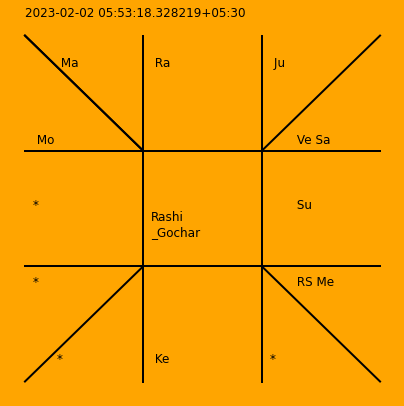

In [ ]:
#p21.pName = p21.gName
p21.cID = cDate
p21utilsR.R12B_drawChart_Bengal()